<a href="https://colab.research.google.com/github/Sharkar96/BHDQN/blob/main/BHDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random as r
import numpy as np
import math as m
from numpy import linalg
from shapely.geometry import Point, Polygon, LineString
from shapely import affinity, distance
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import matplotlib.patches as patches
np.set_printoptions(precision=1)

In [33]:
def point2nparray(p: Point):
  return np.array([p.x, p.y])

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm

maxDivision=1000

def divide(n, d):
  return n / d if d else maxDivision

Parameters

In [17]:
katt=1 #attraction coefficient
kstr=8 #blackhole field coefficient
krep=20 #repulsive coefficient
p0=3 #range of repulsive field
delta=1 #safety distance
delta0=5 #range of repulsive field
ps=8 #range of blackhole field
W1=-10 #collision penalty
W2=10 #reward of completing goals
W3=-0.2 #penalty for each time
alpha=-20 #reward coefficient of potential field
gamma=0.95 #discount rate
ts=1 #sampling time
eps=2 #distance from the goal to be reached
stdDev=0.1 #standard deviation for the gaussian noise

In [4]:
class Obstacle:
  def __init__(self, o: Point, A):
    self.A=A
    self.o=o
    self.obstacle=None
    self.createObstacle(o, A)

  def contains(self, *arg):
    return self.obstacle.contains(arg)

  def createObstacle(self, o: Point, A):
    th=360*r.random()
    rngLength=(r.random()+0.5)*m.sqrt(A)

    vertex=[]
    vertex.append(Point(o.x-rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y-(A/rngLength)/2))
    vertex.append(Point(o.x+rngLength/2,o.y+(A/rngLength)/2))
    vertex.append(Point(o.x-rngLength/2,o.y+(A/rngLength)/2))

    self.obstacle=affinity.rotate(Polygon(vertex),th)

  def polygon2array(self):
    x,y =self.obstacle.exterior.coords.xy
    return[list(a) for a in zip(x,y)]

  def __str__(self):
    return str(self.obstacle)

In [5]:
class Robot:
  def __init__(self, x, y):
    self.x=x
    self.y=y
    #moves: E, NE, N, NW, W, SW, S, SE
    self.moves=['E', 'NE', 'N', 'NW', 'W', 'SW', 'S', 'SE']
    self.possibleMoves= np.array([[1,0],
                             [0.707,0.707],
                             [0,1],
                             [-0.707,0.707],
                             [-1,0],
                             [-0.707,-0.707],
                             [0,-1],
                             [0.707,-0.707]]
                            )

  def compass(self, force):
    return np.dot(force, self.possibleMoves.T)

  def move(self, chosenMove, verbose=False):
    self.x=self.x + np.random.normal(0, stdDev) + ts*self.possibleMoves[chosenMove][0]
    self.y=self.y + np.random.normal(0, stdDev) + ts*self.possibleMoves[chosenMove][1]

    if verbose:
      print(self.moves[chosenMove], end=' ')
      print(np.array([self.x, self.y]))
    return

  def __str__(self):
    return str(np.array([self.x,self.y]))

In [10]:
class Maze:
  def __init__(self, A):
    self.l=m.sqrt(A)
    self.coordinates=np.array([[0,0],
                              [self.l,0],
                              [self.l,self.l],
                              [0,self.l]])
    self.obstacles=[]
    self.goals=[]
    self.robot=None

  def step(self, action):
    def calcReward(pt1, pt2):
      reward=0
      if maze.robot.x <0 or maze.robot.x>self.l or maze.robot.y <0 or maze.robot.y>self.l or self.isGoalOccluded(Point(maze.robot.x, maze.robot.y)):
        reward+=W1
      if self.isGoalReached():
        reward+=W2
      reward+=W3
      reward+=alpha*(pt2-pt1)
      return reward

    pt1=self.potentialField()
    self.robot.move(action)
    pt2=self.potentialField()
    nextState=self.robot.compass(self.gravitationalForce())
    reward=calcReward(pt1, pt2)
    done=self.isGoalReached()
    return nextState, reward, done

  def potentialField(self, p=None):
    if p is None:
      p=np.array([self.robot.x, self.robot.y])

    resultingP=0
    for i in self.goals:
      dis=distance(i, Point(p[0], p[1]))
      #attractive potential
      normalAttP= katt*0.5*(dis)**2

      #black hole potential
      blackHolePmodule=0
      if dis <= ps:
        blackHolePmodule=-0.5*kstr*(ps-dis)**2
      resultingP = resultingP + normalAttP + blackHolePmodule

    #repulsive potential
    for i in self.obstacles:
      dis=distance(i.obstacle, Point(p[0], p[1]))
      repulsiveP=0
      if dis <= delta0:
        repulsiveP=0.5*krep*(divide(1,dis-delta)-divide(1,delta0-delta))**2
      resultingP = resultingP + repulsiveP

    #normalize
    Umin= -0.5*kstr*ps**2
    Umax= 0.5*krep*(maxDivision-1/4)**2 + 0.5*katt*(self.l**2)*1.41
    resultingP=(resultingP-Umin)/(Umax-Umin)
    return resultingP

  #WHAT ABOUT THE NORMALIZATION OF THE POTENTIAL FIELD?
  def gravitationalForce(self, p=None):
    if p is None:
      p=np.array([self.robot.x, self.robot.y])

    resultingF=np.array([0, 0])
    for i in self.goals:
      #attractive force
      normalAttF= -katt*(p - point2nparray(i))

      #black hole force
      dis=distance(i, Point(p[0], p[1]))
      blackHoleF=np.array([0, 0])
      if dis <= ps:
        blackHoleFmodule= kstr*(ps-dis)
        blackHoleF=blackHoleFmodule*normalize(point2nparray(i)-p)
      resultingF = resultingF + normalAttF + blackHoleF

    #repulsive force
    for i in self.obstacles:
      dis=distance(i.obstacle, Point(p[0], p[1])) #for reducing nan in the division
      repulsiveF= np.array([0, 0])
      if dis <= delta0:
        repulsiveFmodule=krep*((1/(dis-delta+0.01))-1/(delta0-delta))*(1/((dis-delta)**2)*1/dis)
        p1, p2 = nearest_points(i.obstacle, Point(p[0], p[1]))
        repulsiveF=repulsiveFmodule*normalize(point2nparray(p2)-point2nparray(p1))
      resultingF = resultingF + repulsiveF
    return resultingF

  #it assumes just 1 robot
  def isGoalReached(self):
    robotPosition= np.array([self.robot.x, self.robot.y])
    for goal in self.goals:
      if linalg.norm(point2nparray(goal)-robotPosition)<=eps:
        return True

    return False

  #check if a goal spawned inside an obstacle
  def isGoalOccluded(self, p: Point):
    for i in self.obstacles:
      if i.contains(p):
        return True
    return False

  #check if the obstacle spawned over a goal
  def isObstacleOccluding(self, p: Polygon):
    for i in self.goals:
      if p.contains(i):
        return True
    return False

  #spawnRobot must be performed after add Obstacles
  def spawnRobot(self, x=None, y=None):
      if x is not None and y is not None:
        if self.isGoalOccluded(Point(x,y)):
          print('Position was eccupied')
        else:
          self.robot=Robot(x,y)
          return

      candidate=Point(r.random()*self.l,r.random()*self.l)
      while self.isGoalOccluded(candidate):
        candidate=Point(r.random()*self.l,r.random()*self.l)
      self.robot=Robot(candidate.x,candidate.y)

  #addGoals and addObstacles can be performed in every order
  def addGoals(self,n=1):
    for i in range(n):
      candidate=Point(r.random()*self.l, r.random()*self.l)
      while self.isGoalOccluded(candidate):
        candidate=Point(r.random()*self.l, r.random()*self.l)
      self.goals.append(candidate)

  def addObstacles(self, n=1):
    #maximum area is 7% of entire maze
    maxA=0.07
    for i in range(n):
      candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      while self.isObstacleOccluding(candidate):
        candidate=Obstacle(o= Point(r.random()*self.l,r.random()*self.l),
                                     A= self.l*self.l*maxA*r.random())
      self.obstacles.append(candidate)

  def print(self):
    print('coordinates: '+ str(self.coordinates))
    print('-------------------')
    print('robot: ' + str(self.robot))
    print('-------------------')
    print('goals: ')
    for i in self.goals:
      print(point2nparray(i))
    print('-------------------')
    print('obstacles: ')
    for i in self.obstacles:
      print(i)
    print('-------------------')

  def plot(self):
    plt.clf()
    #plot the maze
    rectangle = patches.Rectangle((0,0), self.l, self.l,
                              linewidth=1, edgecolor='b', facecolor='none')
    plt.gca().add_patch(rectangle)
    #plot robot
    plt.scatter(self.robot.x, self.robot.y, c='b', marker='o', label='Robot')
    #plot goals
    for goal in self.goals:
         circle= patches.Circle((goal.x, goal.y), eps, edgecolor='g', facecolor='lightgreen', linestyle='--')
         plt.gca().add_patch(circle)
         circle= patches.Circle((goal.x, goal.y), ps, edgecolor='black', facecolor='none',linestyle='--', label='blackhole')
         plt.gca().add_patch(circle)
         plt.scatter(goal.x, goal.y, color='darkgreen', marker='x', label='Goal')
    #plot obstacles
    for obs in self.obstacles:
      poly=patches.Polygon(obs.polygon2array(),edgecolor='r', facecolor='r')
      plt.gca().add_patch(poly)
    plt.gca().set_aspect('equal')
    plt.xticks(range(0, m.ceil(self.l),4))
    plt.yticks(range(0, m.ceil(self.l),4))
    plt.xlim(-1, m.ceil(self.l))
    plt.ylim(-1, m.ceil(self.l))
    plt.legend()
    plt.draw()
    plt.pause(0.1)


In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.optimizers import Adam

In [ ]:
stateSize = 8  # 2D environment, assuming x and y coordinates
nActions = 8  # 8 possible moves
nEpisodes = 10
epsilon = 0.1  # Exploration-exploitation trade-off
ReLUalpha=0.1
learningRate=0.01 #for Adam

In [ ]:
def buildQN(inputShape, nActions):
    model = Sequential()

    # Fully connected layers
    model.add(Dense(32, input_shape=inputShape))
    model.add(LeakyReLU(alpha=ReLUalpha))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=ReLUalpha))

    # Output layer
    model.add(Dense(nActions, activation='linear'))

    # Compile the model
    model.compile(loss='mse', optimizer=Adam(learning_rate=learningRate))
    return model

QN = buildQN((stateSize,), nActions)
#QN.summary()

In [ ]:
maze=Maze(2500)
maze.addGoals(1)
maze.addObstacles(0)
maze.spawnRobot()

for episode in range(nEpisodes):
  print('episode: ' + str(episode) + '/' + str(nEpisodes))
  # Initialize the environment and get the initial state
  state = maze.robot.compass(maze.gravitationalForce())
  done = maze.isGoalReached()
  while not done:
      #epsilon-greedy strategy
      if np.random.rand() < epsilon:
          action = np.random.randint(nActions)
      else:
          qValues = QN.predict(state.reshape(1, -1), verbose=0)
          action = np.argmax(qValues)

      #performes the action chosen by the current QN
      nextState, reward, done = maze.step(action)


      target = reward + gamma * np.max(QN.predict(nextState.reshape(1, -1),verbose=0))
      qValues = QN.predict(state.reshape(1, -1), verbose=0)
      qValues[0, action] = target

      # Train the Q-network on the updated Q-values
      QN.fit(state.reshape(1, -1), qValues, verbose=0)

  maze=Maze(2500)
  maze.addGoals(1)
  i=1
  if episode==i*100 and i<16:
    i+=1
  maze.addObstacles(0)
  maze.spawnRobot()


episode: 0/10
episode: 1/10
episode: 2/10


KeyboardInterrupt: 

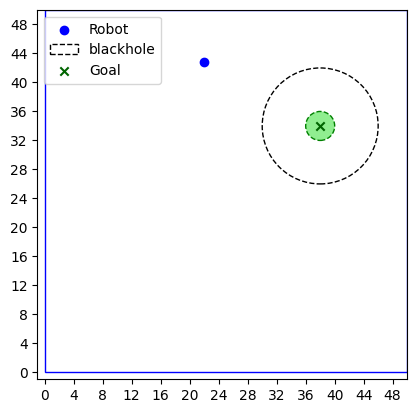

In [11]:
maze=Maze(2500)
maze.addGoals(1)
maze.addObstacles(0)
maze.spawnRobot()
maze.plot()


In [ ]:
epochs=10
plt.ion()
for epoch in range(epochs):
  if maze.isGoalReached():
    print('the goal was reached')
    break
  else:
    state= maze.robot.compass(maze.gravitationalForce())
    print(state)
    qvalues=QN.predict(state.reshape(1, -1))
    print(qvalues)
    chosenMove= np.argmax(qvalues)
    print(maze.robot.moves[chosenMove])
    maze.robot.move(chosenMove)
    maze.plot()

plt.ioff()
plt.show()

coordinates: [[ 0.  0.]
 [50.  0.]
 [50. 50.]
 [ 0. 50.]]
-------------------
robot: [14.8 23.8]
-------------------
goals: 
[43.5 36.9]
-------------------
obstacles: 
POLYGON ((26.135849927833004 31.002597178157345, 14.589180840144786 21.679629335218088, 20.709887143391224 14.099020728910517, 32.25655623107944 23.421988571849774, 26.135849927833004 31.002597178157345))
POLYGON ((18.210485042951063 33.108016917861335, 21.154647613993667 26.209453050999706, 25.519782778845148 28.072401313555147, 22.575620207802544 34.970965180416776, 18.210485042951063 33.108016917861335))
POLYGON ((18.983782741441622 36.458171050426415, 23.044648541377455 26.439788756868513, 37.61189235340525 32.34449676882263, 33.55102655346942 42.36287906238053, 18.983782741441622 36.458171050426415))
-------------------


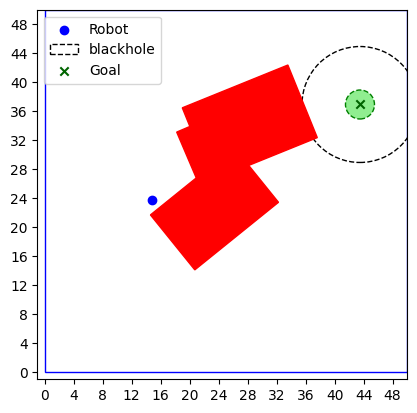

In [31]:
#for testing the first part of the program
maze=Maze(2500)
maze.addGoals(1)
maze.addObstacles(3)
maze.spawnRobot()
maze.print()
maze.plot()


498.20461956599564


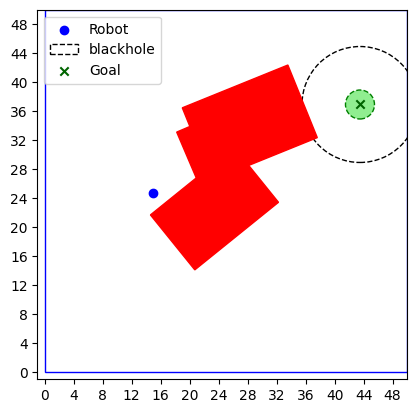

483.33235236079975


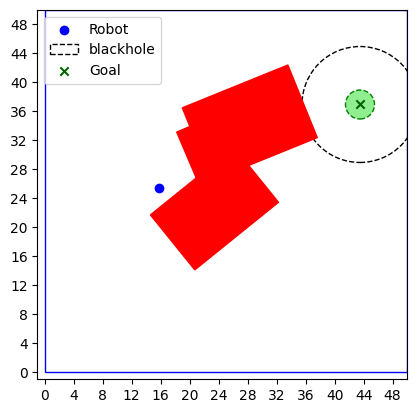

450.97900927333666


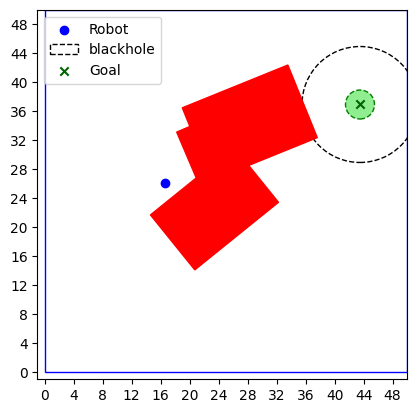

420.29922228903007


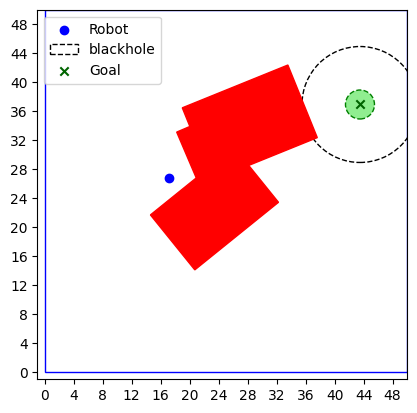

397.62773182171225


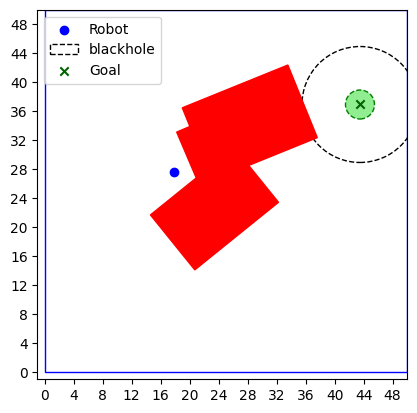

371.105565194442


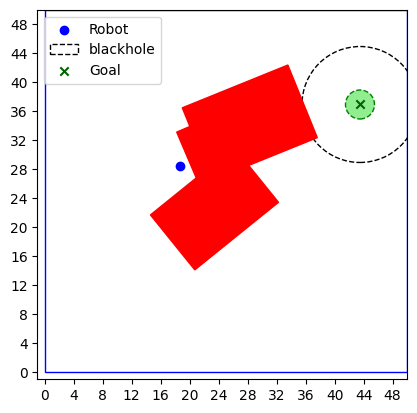

344.7825726972869


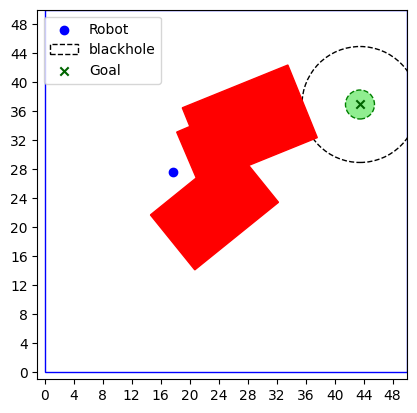

374.47339563873436


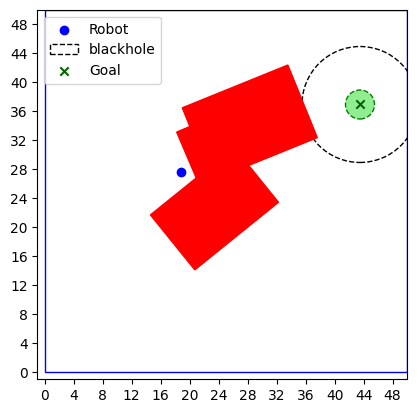

349.43329575326084


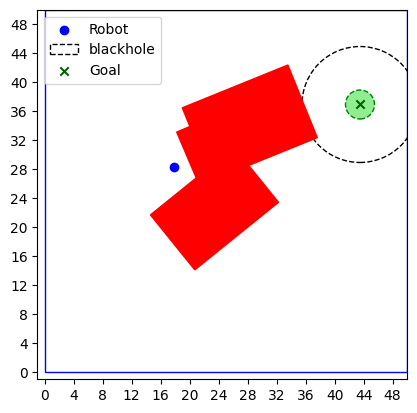

364.3628471418256


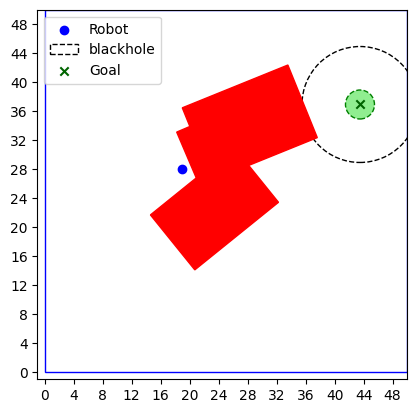

341.2805977566277


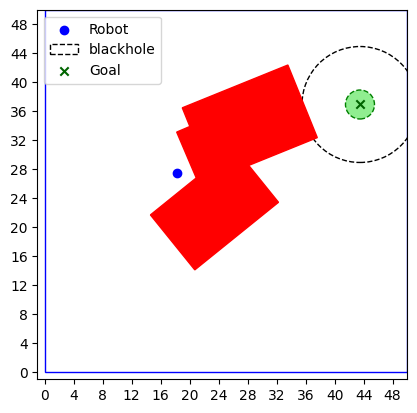

361.90543866721123


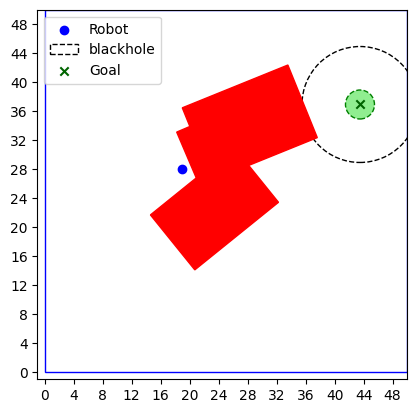

338.7108825134382


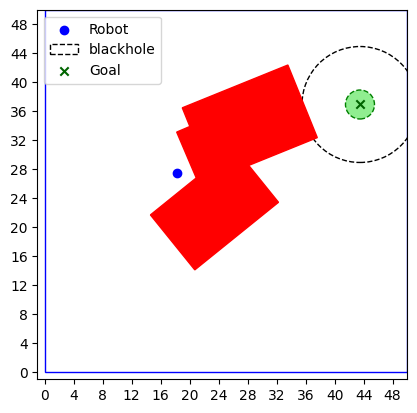

362.7760648832012


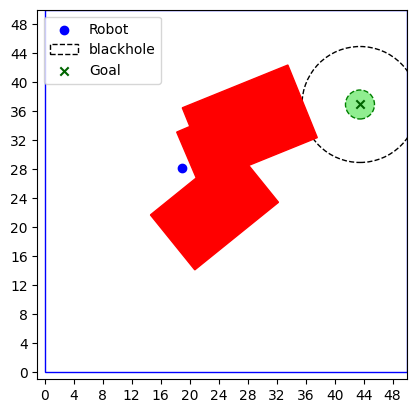

339.8229305568188


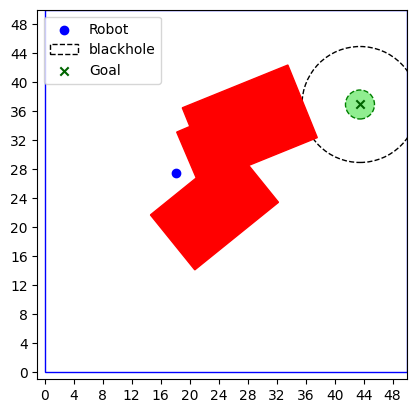

366.05169309360076


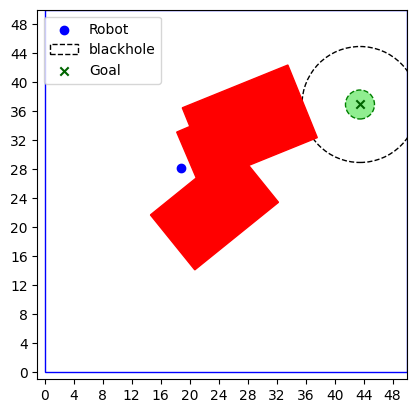

343.13563863333104


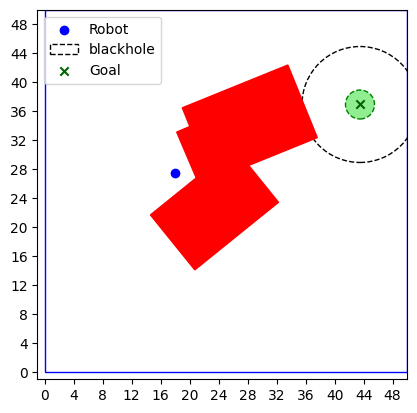

367.9704545779498


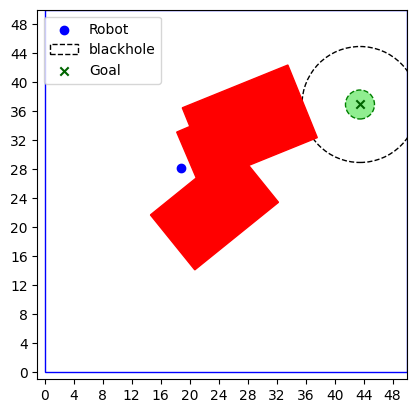

343.5717348171003


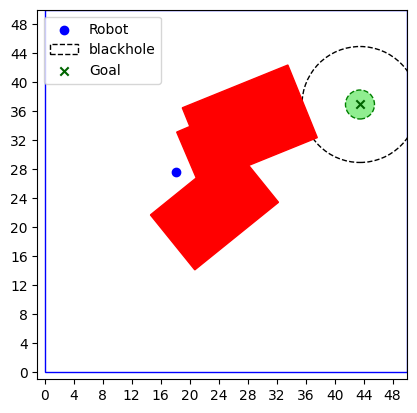

366.081007119009


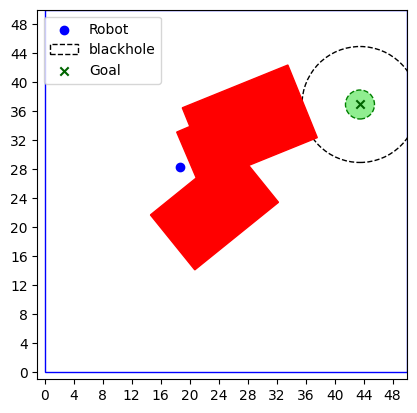

343.44801160544415


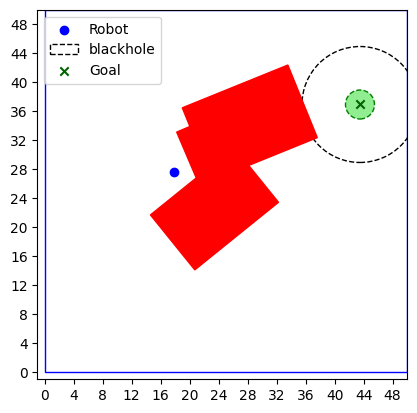

371.69059122365735


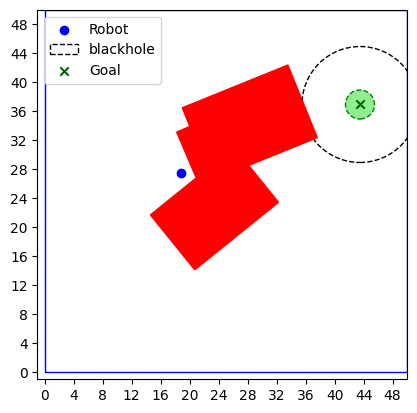

348.28377233757345


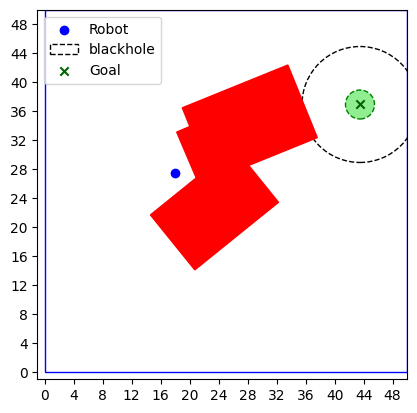

369.6133940558413


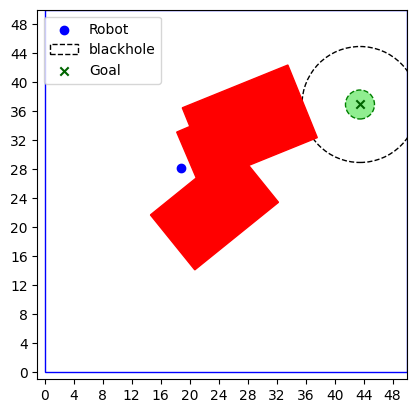

342.8397628262798


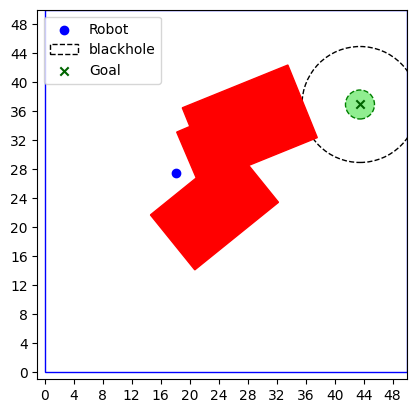

366.4578444641613


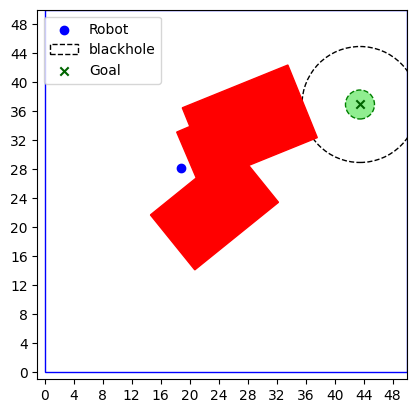

343.70467614553576


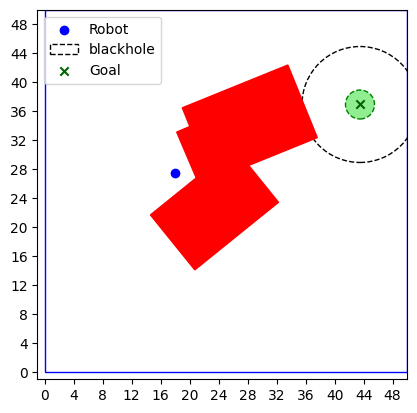

369.6333893837156


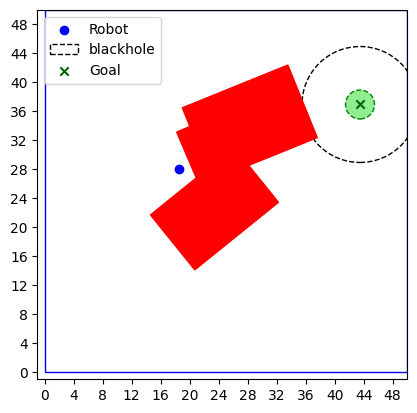

351.227932388


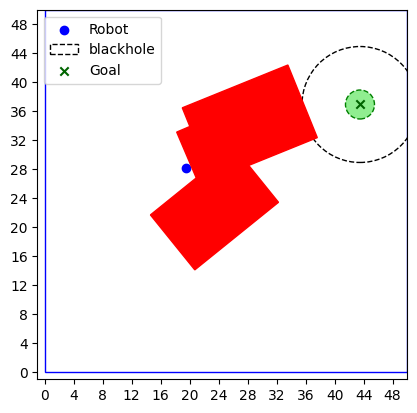

326.96519433838887


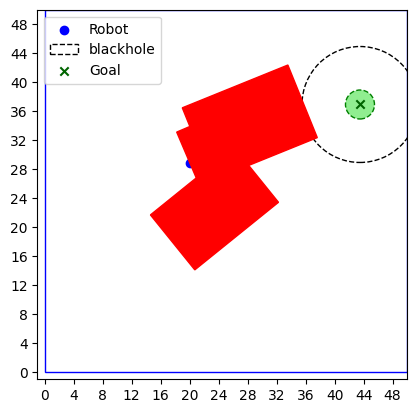

<ipython-input-10-7d5b4c035d10>:81: RuntimeWarning: divide by zero encountered in double_scalars
  repulsiveFmodule=krep*((1/(dis-delta+0.01))-1/(delta0-delta))*(1/((dis-delta)**2)*1/dis)
<ipython-input-10-7d5b4c035d10>:83: RuntimeWarning: invalid value encountered in multiply
  repulsiveF=repulsiveFmodule*normalize(point2nparray(p2)-point2nparray(p1))


306.63791336741264


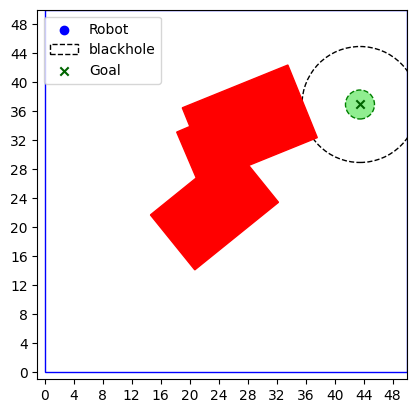

286.83858329634006


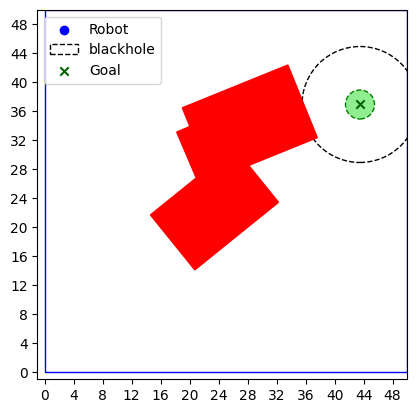

262.7293795495101


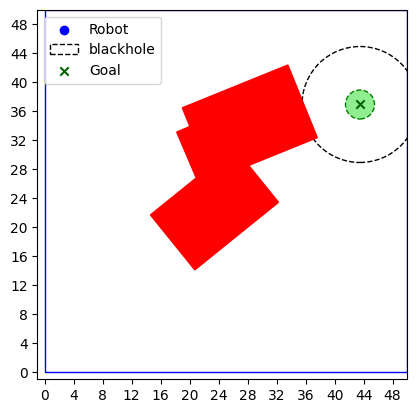

241.29480126601013


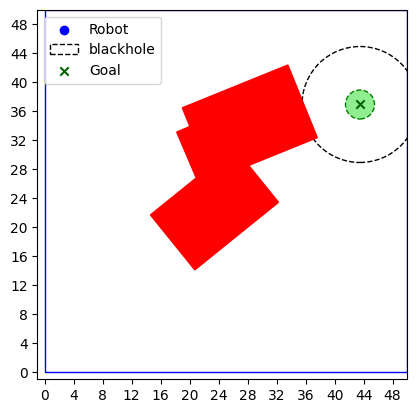

222.2391429533194


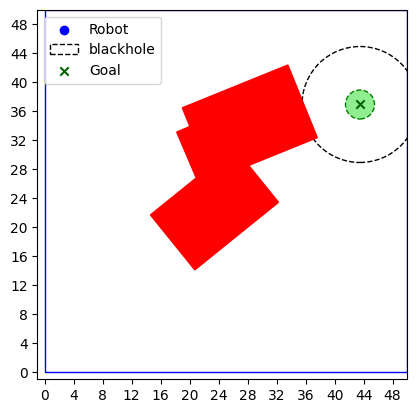

202.7914237986159


KeyboardInterrupt: 

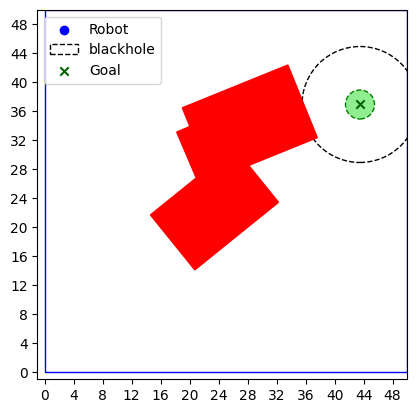

In [32]:
#for testing the first part of the program

epochs=100
plt.ion()
for epoch in range(epochs):
  if maze.isGoalReached():
    print('the goal was reached')
    break
  else:
    chosenMove= np.argmax(maze.robot.compass(maze.gravitationalForce()))
    print(maze.potentialField())
    maze.robot.move(chosenMove)
    maze.plot()

plt.ioff()
plt.show()
